In [1]:
# Notebook to plot qlens source and image plots from data files
# v4: Calculates distances of innermost and outermost data images

In [2]:
import time
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import pandas as pd
import timeit
from IPython.core.debugger import set_trace
import datetime
from matplotlib.backends.backend_pdf import PdfPages
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s /u.Mpc, Om0=0.3)
print(cosmo)
writefile = True

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


In [3]:
print( os.getcwd())

/Users/kevin/CloudStation/KEVIN/UCI/Research/gravlensing/Python


In [4]:
name = 'mock_halo_2'
display_name = 'Illustris Mock Halo #2'  # For Abell clusters, use A####
dirname = 'mock_halo_2'
suffix = '.v15k2'
datdic = {'A611': 'Abell_611_Donnarumma_ABv2g.dat',  'A2537': 'A2537_SL_Data.dat',  'MS2137':
          'MS2137_SL_Data_V4.dat', 'mock_halo_2':'mock_halo_2.SL_Data.v2.dat'}
datfile = datdic[name]   #REVIEW
print('Using datfile ', datfile)

Using datfile  mock_halo_2.SL_Data.v2.dat


In [5]:
datapath = '/Users/kevin/CloudStation/KEVIN/UCI/Research/gravlensing/' + dirname + '/'
os.chdir(datapath)
print(os.getcwd())

/Users/kevin/CloudStation/KEVIN/UCI/Research/gravlensing/mock_halo_2


In [6]:
filetag = 'chains_' + name + suffix +'/' + name + suffix 
srcfile = filetag + '.sourcepic'
imgfile = filetag + '.imagepic'
critfile = filetag + '.crits'
assert os.path.isfile(srcfile) , 'Missing ' + srcfile
assert os.path.isfile(imgfile)
assert os.path.isfile(critfile)
assert os.path.isfile(datfile), 'Missing ' + str(datfile)

In [7]:
with open(datapath+critfile,'r') as file:
    # Catalog the blank lines, as they indicate delimiters between different curves.
    blankline = [-1]
    for i, line in enumerate(file):
        if line[0] == '#' or not line.strip():
            blankline.append(i)
    # put another one at the very end
    blankline.append(i)
    print( 'Blank/comment line list', blankline)
    num = len(blankline) - 1  # this is the number of curves
    # now we need to know how many elements the largest one has
    maxsize = 0
    lastelem = -1
    for b in blankline[1:]:
        diff = b - lastelem
        maxsize = np.maximum(maxsize, diff)
        lastelem = b
    print( 'Largest curve is of length ', maxsize)
    critcurves = np.full((num, maxsize, 2), np.NaN)
    caustics = np.full((num, maxsize, 2), np.NaN)
    # Now read in the data
    intab = np.loadtxt(critfile) # note that numpy skips blank lines and comments
    lastline = -1
    curve = 0
    for i, b in enumerate(blankline[1:]):
        if b - lastline >1:
            num_pts = b - lastline - 2
            start_pt = lastline + 1 -i
            end_pt = start_pt + num_pts
            critcurves[curve, 0:num_pts] = intab[start_pt:end_pt, 0:2]
            critcurves[curve, num_pts] = critcurves[curve, 0]  # close the loop
            caustics[curve, 0:num_pts] = intab[start_pt:end_pt, 2:4]
            caustics[curve, num_pts] = caustics[curve, 0]  # close the loop
            curve +=1
        lastline = b
    print( curve, ' curves found.')

Blank/comment line list [-1, 433, 444, 1130, 1146, 1162, 1172, 1177, 1224, 1251, 1265]
Largest curve is of length  686
10  curves found.


In [8]:
curve, num_pts, start_pt, end_pt

(10, 12, 1243, 1255)

In [9]:
# now read in the source and image points
with open(datapath+srcfile,'r') as file:
    # note that in this file, #'s do not indicate comments
    srcname = []
    srccoord = []
    while True:
        line = file.readline()
        if not line: break
        if line[0] == '#':
            srcname.append(line[1:].strip().strip('"'))
            srccoord.append([float(item) for item in file.readline().strip('\n').split(' ')])

            
tot_model_images = 0
with open(datapath+imgfile,'r') as file:
    # note that in this file, #'s do not indicate comments
    imgname = []
    imgcoord = np.full((30, 30, 2), np.NaN) # format is (image, subimage, x, y)
    img = -1
    mod_subimgs = []
    subimg_flag = False
    while True:
        line = file.readline()
        if not line: break   
        if line[0] == '#':
            imgname.append(line[1:].strip().strip('"'))
            img +=1
            subimg = 0
            subimg_flag = False
        elif line.strip():
            imgcoord[img, subimg, 0:2] = [float(item) for item in line.strip('\n').split(' ')]
            subimg +=1
            subimg_flag = True
            tot_model_images +=1
        else:
            if subimg_flag: # if a blank line and the last line was a subimage, append
                mod_subimgs.append(subimg)
                subimg_flag = False
print(img+1, ' modeled image groups')
print(tot_model_images, ' modeled images')
print('Modeled subimages: ', mod_subimgs)
print(np.sum(mod_subimgs))

12  modeled image groups
50  modeled images
Modeled subimages:  [5, 5, 2, 3, 4, 2, 5, 5, 5, 5, 4, 5]
50


In [10]:
# read in observed data
# had to modify this to work with Donnarumma format
def getline(file): # reads a line, returns True and the non-comment portion unless file is at its end
    line = file.readline()
    if not line:
        return (False, '(not length zero)')
    hashpos = line.find('#')
    if hashpos != -1:
        endpos = np.minimum(len(line), hashpos)
    else:
        endpos = len(line)
    return (True, line[:endpos].strip().strip('"'))
    

In [11]:
# had to modify this to work with Donnarumma format.
tot_dat_images = 0
inner_rad_kpc = 1.e10
outer_rad_kpc = 0.
with open(datapath+datfile,'r') as file:
    # in these files, # indicates a comment
    redshift = []
    subimgs = []
    datcoord = np.full((30, 30, 2), np.NaN) # format is (image, subimage, x, y)
    while True:
        line =''
        while len(line) == 0:
            notend, line = getline(file)
        if not notend: break
        sstr = "zlens ="
        sstr2 = "zlens="  # Can handle either case now.
        if (sstr in line) or (sstr2 in line):
            startpos= line.index("zlens") + (len(sstr) if sstr in line else len(sstr2))
            zlens = float(line[startpos : len(line)])
        # the next number on a non-blank line should be the number of sources
        line =''
        while len(line) == 0:
            notend, line = getline(file)
        if not notend: break
        imgcount = int(line)
        print( 'zlens = ', zlens)
        kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(zlens) * u.arcmin / (60. * u.arcsec)
        print(f'{kpc_per_arcsec:.3f}')
        # now get rid of units
        kpc_per_arcsec = kpc_per_arcsec.value
        print( imgcount, 'image groups')
        for i in range(imgcount):
            # next comes a line with the number of images for that source, and the redshift
            line =''
            while len(line) == 0:
                notend, line = getline(file)
            if not notend: break
            subimgcount, imgredshift = [float(item) for item in line.strip('\n').split()]
            subimgcount = int(subimgcount)
            tot_dat_images +=subimgcount
            subimgs.append(subimgcount)
            redshift.append(imgredshift)
            # now need to loop through each subimage and store coordinates
            for j in range(subimgcount):
                line =''
                while len(line) == 0:
                    notend, line = getline(file)
                if not notend: break
                datlist = line.strip('\n').split()
                if len(datlist) == 7: # Donnarumma data had 7 columns, including time delay and error
                    x, y, poserr, flux, fluxerr, tdel, tdelerr = [float(item) for item in datlist]
                elif len(datlist) == 5: # mock data had only 5 columns
                    x, y, poserr, flux, fluxerr = [float(item) for item in datlist]
                else:
                    sys.exit()
                datcoord[i, j] = x, y
                dist_kpc = np.sqrt(x **2 + y **2) * kpc_per_arcsec
                if dist_kpc < inner_rad_kpc:
                    inner_rad_kpc = dist_kpc
                if dist_kpc > outer_rad_kpc:
                    outer_rad_kpc = dist_kpc

        # that should be the whole file
print(tot_dat_images, 'total data images')     
print('Subimages: ', subimgs)
print(np.sum(subimgs))
print(f'Innermost data point (kpc): {inner_rad_kpc:.2f}     Outermost data point (kpc): {outer_rad_kpc:.2f}')

zlens =  0.3
4.454 kpc / arcsec
12 image groups
41 total data images
Subimages:  [4, 5, 2, 2, 4, 2, 2, 4, 4, 4, 4, 4]
41
Innermost data point (kpc): 36.13     Outermost data point (kpc): 161.21


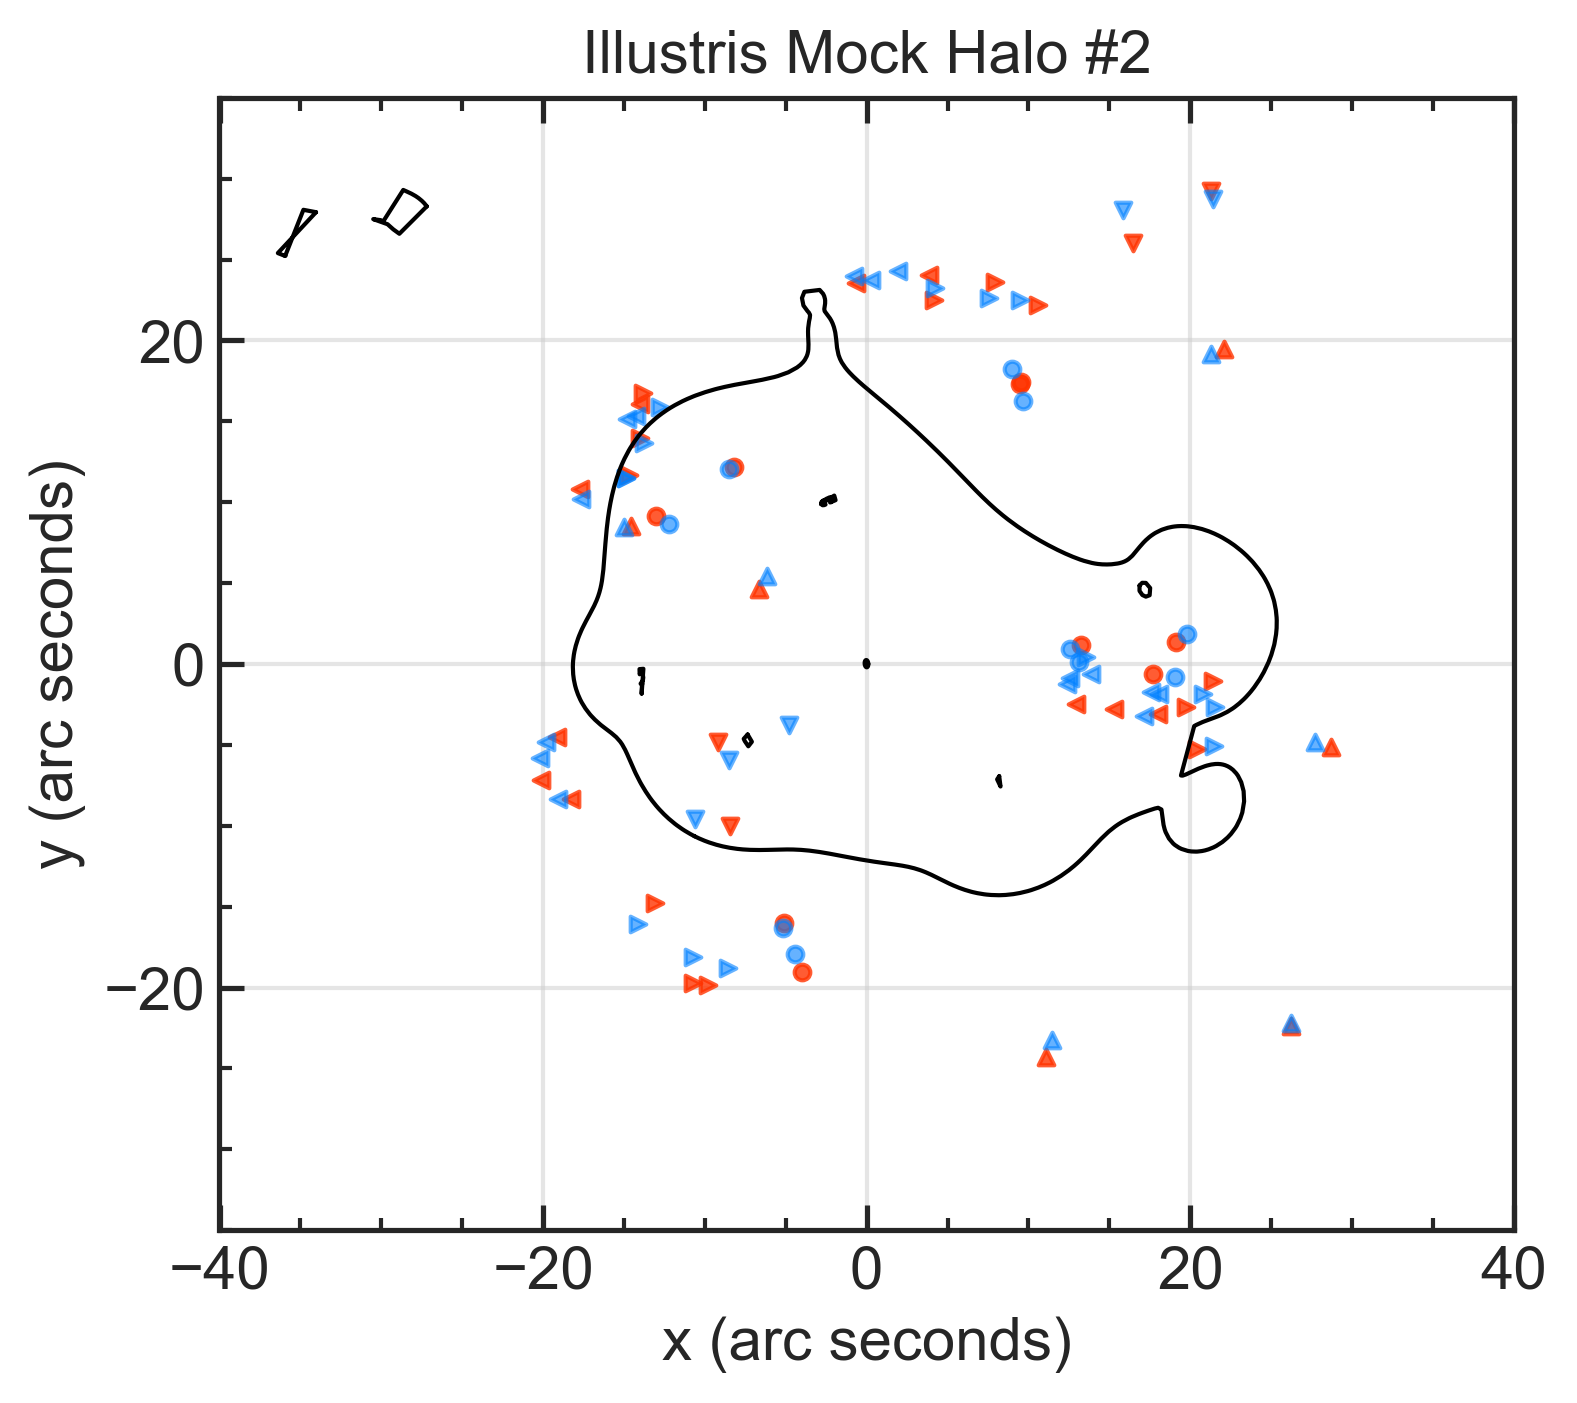

In [19]:
# plot the curves
plt.rcParams["figure.dpi"] = 300
# plt.rcParams["figure.figsize"] = [8.3, 6]
plt.rcParams.update({'legend.fontsize': 'large',
          'figure.figsize': (6, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'legend.frameon': True })
markers = 'ov^<>xsp+*hxDdov^<>xsp+*hxDd'
markersize = 14
colors = ['red', 'lightblue', 'orange', 'yellow', 'green', 'purple', 'magenta', 'grey', 'pink', 'teal',\
          'darkblue', 'tan', 'darkgreen', 'cyan', 'olive', 'brown', 'maroon', 'salmon', 'fuscia']
plt.style.use('seaborn-ticks')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(-100, 100, 20)
minor_ticks = np.arange(-100, 100, 5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.tick_params(
    axis='both',
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    direction='in',    # ticks go inward
    labelbottom='on') # labels along the bottom edge are off

# And a corresponding grid
# ax.grid(which='major')

# Or if you want different settings for the grids:
# ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.axis('equal')
ax.set_title(display_name)
# first, plot the input data
ax.scatter( 0, 0, color='None', label='Data')  # This is a way to put a labeling line in the legend.

currentredshift = -999
redshiftgroup_count = 0
for i in range(imgcount):
    if redshift[i] != currentredshift:
        newredshiftgroup = True
        currentredshift = redshift[i]
        redshiftgroup_count += 1
    for j in range(subimgs[i]):
        x, y = datcoord[i, j, 0:2]
        color2 = (1., 0.2, 0., .8)
        if True: # can put a redshift selector here if you want
            if newredshiftgroup and j==0:
                ax.scatter(x, y, marker=markers[redshiftgroup_count - 1], color=color2, label=\
                          'z = ' +str(redshift[i]), s=markersize)
            else:
                ax.scatter(x, y, marker=markers[redshiftgroup_count - 1], color=color2, s=markersize)
    newredshiftgroup = False

# now plot the images found by qlens
ax.scatter( 0, 0, color='None', label=' ')
ax.scatter( 0, 0, color='None', label='Modeled Images')  # This is a way to put a labeling line in the legend.
currentredshift = -999
redshiftgroup_count = 0
for i, label in enumerate(imgname):
    if redshift[i] != currentredshift:
        newredshiftgroup = True
        currentredshift = redshift[i]
        redshiftgroup_count += 1
    for j, (x, y) in enumerate(imgcoord[i]):
        if True: # can put a redshift selector here if you want
            if newredshiftgroup and j == 0:
                color1 = (0., 0.5, 1.0, 0.6)
                ax.scatter(x, y, marker=markers[redshiftgroup_count - 1], color=color1,\
                           label='z = ' +str(redshift[i]), s=markersize)
            elif not (np.isnan(x) or np.isnan(y)):
                ax.scatter(x, y, marker=markers[redshiftgroup_count - 1], color=color1, s=markersize)
    newredshiftgroup = False
            
ax.set_xlabel('x (arc seconds)')
ax.set_ylabel('y (arc seconds)')
# ax.annotate(s= name + suffix, xy=(.06, .06), xycoords = 'axes fraction')
# ax.legend(frameon=True, loc='upper left', fontsize='small', framealpha = .5) #loc='center left', bbox_to_anchor=(1, 0.5))

# Alternative legend
# these are matplotlib.patch.Patch properties
# props = dict(boxstyle='square', facecolor='white')
# textstr = 'Model: Blue\nData: Red'
# # place a text box in upper left in axes coords
# ax.text(0.05, 0.15, textstr, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)

ax.set_xlim(-40, 40)  # use this to get the legend off of the critical curve
ax.set_ylim(-35, 35)
plt.gca().set_adjustable("box")

for i in critcurves:
    ax.plot(i[:, 0], i[:, 1], color='black', linewidth=1)
if writefile:
    plt.savefig(filetag + '_ip.png', dpi='figure')
plt.show()
plt.close(fig)

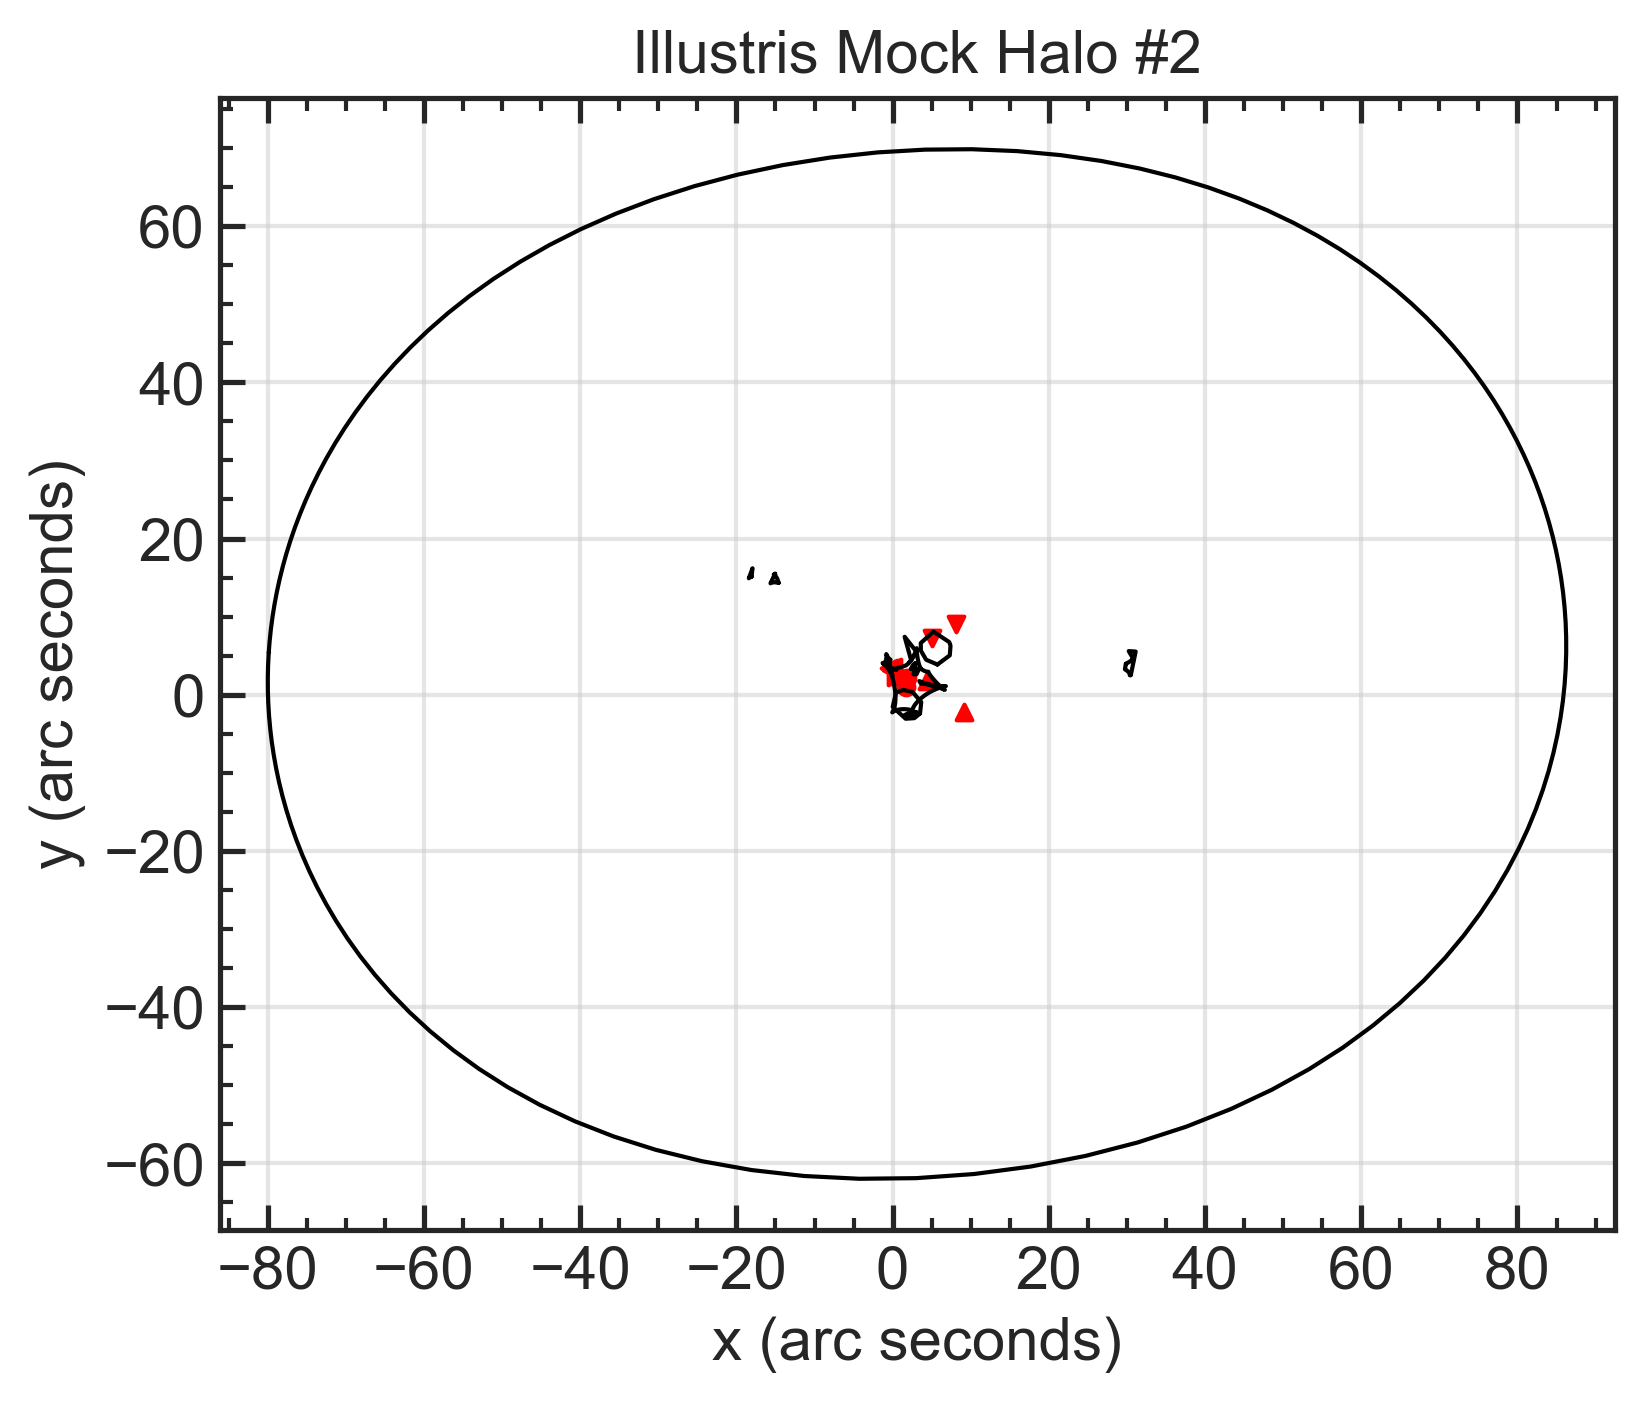

In [20]:
##################################
# source plane
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(-100, 100, 20)
minor_ticks = np.arange(-100, 100, 5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.tick_params(
    axis='both',
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    direction='in',    # ticks go inward
    labelbottom='on') # labels along the bottom edge are off


# And a corresponding grid
# ax.grid(which='major')

# Or if you want different settings for the grids:
# ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.axis('equal')
plt.title(display_name)
currentredshift = -999
redshiftgroup_count = 0
for i, (point, label, rs) in enumerate(zip(srccoord, srcname, redshift)):  # note: using redshift from the other file, hopefully ok.
    if redshift[i] != currentredshift:
        newredshiftgroup = True
        currentredshift = redshift[i]
        redshiftgroup_count += 1
        plt.scatter(point[0], point[1],  marker=markers[redshiftgroup_count - 1],\
                    color='red', label='z = ' +str(redshift[i]), s=markersize)
#         print(point[0], point[1])
    else:
        plt.scatter(point[0], point[1],  marker=markers[redshiftgroup_count - 1],\
                    color='red', s=markersize)
plt.xlabel('x (arc seconds)')
plt.ylabel('y (arc seconds)')
# ax.annotate(s= name + suffix, xy=(.06, .06), xycoords = 'axes fraction')
# plt.legend(frameon=True, loc='upper left') #loc='center left', bbox_to_anchor=(1, 0.5))
for i in caustics:
    plt.plot(i[:, 0], i[:, 1], color='black', linewidth=1)
if writefile:
    plt.savefig(filetag + '_sp.png', dpi='figure')
plt.show()
plt.close(fig)

In [14]:
# plt.style.available

In [15]:
# plt.rcParams.keys()